In [1]:
#Sets up Pauli matrices to create classical simulation of XY Model.
import numpy as np
from scipy import linalg

def GetZ(j, n):
    z = np.array([[1, 0], [0, -1]])
    if j != 1 and j != n:
        Z = np.kron(np.kron(np.identity(2**(j-1)), z), np.identity(2**(n-j)))
    elif j == 1 and j != n:
        Z = np.kron(z, np.identity(2**(n-1)))
    elif j == n and n != 1:
        Z = np.kron(np.identity(2**(n-1)), z)
    else:
        Z = z
    return Z

def GetX(j, n):
    x = np.array([[0, 1], [1, 0]])
    if j != 1 and j != n:
        X = np.kron(np.kron(np.identity(2**(j-1)), x), np.identity(2**(n-j)))
    elif j == 1 and j != n:
        X = np.kron(x, np.identity(2**(n-1)))
    elif j == n and n != 1:
        X = np.kron(np.identity(2**(n-1)), x)
    else:
        X = x
    return X

def GetY(j, n):
    Y = 1j*GetX(j, n).dot(GetZ(j, n))
    return Y

## XY Model

$$ H = \sum_{j=1}^{n-1} (\frac{1+r}{2}X_jX_{j+1} + \frac{1-r}{2}Y_jY_{j+1}) + h\sum_{j=1}^n Z_j$$

In [2]:
#Returns matrix Hamiltonian for XY Model with given parameter values using Pauli matrices.
def XY(n, J, r, h):
    H = np.zeros((2**n, 2**n))
    for j in range(1, n):
        H += J*((1+r)/2*GetX(j, n).dot(GetX(j+1, n)) + (1-r)/2*GetY(j, n).dot(GetY(j+1, n)).real.astype('float64'))
    for j in range(1, n+1):
        H += h*GetZ(j, n)
    return H

## RTR vs. Lie-Trotter-Suzuki

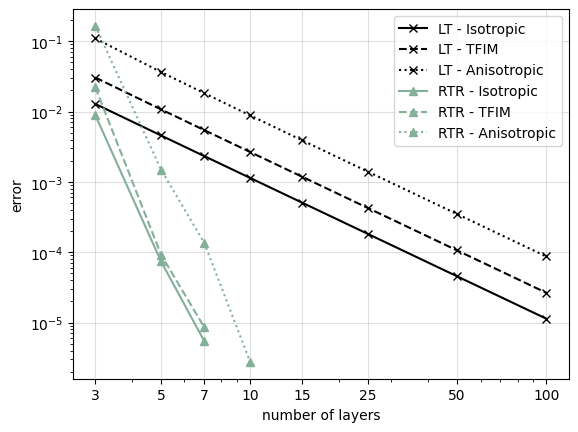

In [21]:
#Function to create a graph demonstrating the difference in errors between Lie-Trotter-Suzuki and RTR for different circuit depths.

#Sets up Hamiltonian parameters to be tested.
n = 5
t = 1
J = 1
r = [0, 1, 1.5]
h = [0, 0.5, 1]

#Sets up variables for the circuit depth and the error.
Gates = [3, 5, 7, 10, 15, 25, 50, 100]
errors = [[], [], []]

#For each Hamiltonian parameter set, creates Lie-Trotter-Suzuki Hamiltonian approx with given circuit depth and calcuates Frobenius error.
for k in range(0, 3):
    H = XY(n, J, r[k], h[k])
    for gates in Gates:

        #The size of each time layer in LT.
        δ = t/gates

        #Creates exact matrix for calculating Frobenius error.
        Uexact = linalg.expm(-1j*t*H)

        #Generates the LT approx matrix via matrix multiplication of smaller matrices.
        Uapprox = np.identity(2**n)
        for i in range(1, gates+1):
            for j in range(1, n):
                Uapprox = linalg.expm(-1j*t*J*((1+r[k])/2)*δ*(GetX(j, n) @ GetX(j+1, n))) @ Uapprox
            for j in range(1, n):
                Uapprox = linalg.expm(-1j*t*J*((1-r[k])/2)*δ*(GetY(j, n) @ GetY(j+1, n))) @ Uapprox
            for j in range(1, n+1):
                Uapprox = linalg.expm(-1j*t*h[k]*δ*(GetZ(j, n))) @ Uapprox

        #Calculates and stores the Frobenius error.
        errors[k].append(1-np.trace(Uexact.conj().T @ Uapprox).real/2**n)

#Plots graph showing log(error) against log(circuit depth) for LT and RTR.
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.loglog(Gates, errors[0], color = 'k', label = 'LT - Isotropic', marker = 'x')
ax.loglog(Gates, errors[1], color = 'k', linestyle = '--', label = 'LT - TFIM', marker = 'x')
ax.loglog(Gates, errors[2], color = 'k', linestyle = 'dotted', label = 'LT - Anisotropic', marker = 'x')

#RTR error values calculated using RTRerrorTest.m and then copied over.
ax.loglog(Gates[:3], [0.008892, 7.425e-5, 5.429e-6], color = (133/256, 176/256, 154/256), label = 'RTR - Isotropic', marker = '^')
ax.loglog(Gates[:3], [0.02215, 9.229e-5, 8.572e-6], color = (133/256, 176/256, 154/256), linestyle = '--', label = 'RTR - TFIM', marker = '^')
ax.loglog(Gates[:4], [0.1648, 0.001495, 1.357e-4, 2.756e-6], color = (133/256, 176/256, 154/256), linestyle = 'dotted', label = 'RTR - Anisotropic', marker = '^')
ax.grid(alpha = 0.4)

#Sets up axis headings, title and the legend.
ax.set(xlabel = 'number of layers', ylabel = 'error')
plt.xticks(Gates, Gates)
ax.legend()

## Classical Computation of Operator Spreading

In [4]:
#Set up number of qubits for system and the time-length over which OTOCs are calculated, with time being the number of
#discrete time intervals and tau being the size of each interval. C is then the array for storing the calculated OTOC
#values, and X and Y are used for creating the wireframe plot.
qubits = 5
time = 101
tau = 0.05
C =  np.zeros((qubits, time))
X = np.zeros((qubits, time))
Y = np.zeros((qubits, time))

#Inputs the parameters for the Hamiltonian.
J = 1
r = 1
h = 0.5

#Creates the Hamiltonian matrix with the given parameter values.
H = XY(qubits, J, r, h)

# #Used to calculate the ground state eigenvctor for investigating zero temp instead of infinite temp state.
# eigenvalues, eigenvectors = np.linalg.eig(H)
# idx = np.argsort(eigenvalues)
# eigenvalues = eigenvalues[idx]
# eigenvectors = eigenvectors[:, idx]
# state = eigenvectors[:, 0]

#Array used to store the spreading time for each qubit.
spread = np.zeros((qubits, 3))

#Sets up the W matrices on the first qubit, which are then averaged over to find the operator-averaged OTOC.
W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
    
#For each lattice point j and time value t*tau, calculates the operator-averaged OTOC and stores the result in C.
for t in range(0, time):
    #Time evolution operator for given time increment t*tau.
    U = linalg.expm(-1j*t*tau*H)
    for j in range(1, qubits+1):

        #Sets up the V matrices on qubit j, which are then averaged over to find the operator-averaged OTOC.
        V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]

        #The x-value for the spreading time curve is stored as the qubit number j.
        spread[j-1][0] = j

        #For each Pauli matrix in V and W the commutator C = 2-2*Re(F) is calculated and added together.
        for k in range(0, 4):

            #F = U^dagger @ W @ U @ V @ U^dagger @ W @ U @ V is calculated in a computationally efficient manner.
            A = U.conj().T @ W[k] @ U
            for l in range(0, 4):              
                B = A @ V[l]
                F = B @ B

                #For zero temp state the OTOC is calculated using the ground state calculated earlier; for infinite temp state the OTOC is
                #calculated via the trace of F, appropriately normalised.
                # F = state.conj().T @ F @ state
                F = np.trace(F)/(2**qubits)

                #Commutator is calculated from the OTOC F and added to C.
                C[j-1][t] += 2-2*F.real

        #Commutator is normalised to find the operator-averaged commutator.
        C[j-1][t] = C[j-1][t]/16

        #Finds the spreading time for qubit j as t_spread = min_t{C_j(t)>0.1}.
        if C[j-1][t] > 0.1 and spread[j-1][2] == 0 and t>0:
            spread[j-1][1] = (t-1)*tau
            spread[j-1][2] = 1

        #Sets up values to create wireframe plot.
        X[j-1][t] = j
        Y[j-1][t] = t*tau

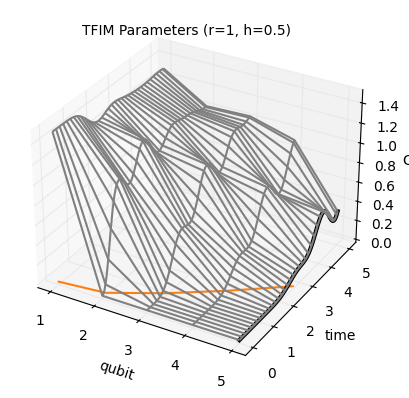

In [5]:
#Plots C as a wireframe against j and t (in units of tau).
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_wireframe(X, Y, C, color = 'grey')

#Plots the spreading time curve along the C=0 plane.
ax.plot(spread[:, 0], spread[:, 1], zs = 0, color = 'C1')
ax.plot([5 for x in Y[4]], Y[4], C[4], color = 'k', linewidth = 3)

#Creates title and axis labels for wireframe plot.
ax.set(xlabel = 'qubit', ylabel = 'time', zlabel = 'C(t)')
plt.suptitle("TFIM Parameters (r=1, h=0.5)", fontsize = 10, y = 0.85)

#Adjusts opacity of grid lines to improve readability of the wireframe.
ax.xaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.8)  # Light gray, semi-transparent
ax.yaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.8)
ax.zaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.8)

## Butterfly Velocity from Line of Best Fit

In [63]:
# Set up number of qubits for model.
qubits = 5

#Inputs the parameters for the Hamiltonian.
J = 1
r = 1
h = 0.5

#Creates the Hamiltonian matrix with the given parameter values.
H = XY(qubits, J, r, h)

# #Used to calculate the ground state eigenvctor for investigating zero temp instead of infinite temp state.
# eigenvalues, eigenvectors = np.linalg.eig(H)
# idx = np.argsort(eigenvalues)
# eigenvalues = eigenvalues[idx]
# eigenvectors = eigenvectors[:, idx]
# state = eigenvectors[:, 0]

#Creates an array to store the spreading time values for each qubit.
spread =  np.zeros((qubits, 2))

#Sets up the W matrices on the first qubit, which are then averaged over to find the operator-averaged OTOC.
W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]

#For each qubit j, the spreading time is calculated via t_spread = min_t{C_j(t)>0.1} up to 0.01 precision.
for j in range(1, qubits+1):

    #Sets up the V matrices on qubit j, which are then averaged over to find the operator-averaged OTOC.
    V = [np.identity(2**qubits), GetX(j, qubits), GetY(j, qubits), GetZ(j, qubits)]

    #spreadCheck is an array used to find the spreading time to increasing orders of precision efficiently.
    spreadCheck = np.zeros((3, 1))

    #Program will increment in time steps of 1 until the spreading time has been found to order 1, then takes a step back and 
    #increments in time steps of 0.1 until the spreading time has been found to order 0.1, then takes a step back and increments
    #in time steps of 0.01 until the spreading time has been found to order 0.01.
    t = 0
    while spreadCheck[2] == 0:

        #Increments the time based on which precision level has been reached.
        if spreadCheck[1] == 1:
            t += 0.01
        elif spreadCheck[0] == 1:
            t += 0.1
        else:
            t += 1

        #Time evolution operator for given time t.
        U = linalg.expm(-1j*t*H)

        
        C = 0
        #For each Pauli matrix in V and W the commutator C = 2-2*Re(F) is calculated and added together.
        for k in range(0, 4):

            #F = U^dagger @ W @ U @ V @ U^dagger @ W @ U @ V is calculated in a computationally efficient manner.
            A = U.conj().T @ W[k] @ U
            for l in range(0, 4):              
                #Calculates OTOC functions F and then C for given j and t*tau.
                B = A @ V[l]
                F = B @ B
                
                #For zero temp state the OTOC is calculated using the ground state calculated earlier; for infinite temp state the OTOC is
                #calculated via the trace of F, appropriately normalised.
                F = np.trace(F)/(2**qubits)
                # F = state.conj().T @ F @ state

                #Commutator is calculated from the OTOC F.
                C += 2-2*F.real

        #Commutator is appropriately normalised to find the operator-averaged commutator.
        C = C/16

        #Checks if the spreading time has been reached to the appropriate level of precision, and then updates the precision level if so.
        if C > 0.1:
            if spreadCheck[1] == 1:
                spread[j-1][0] = t-0.01
                spreadCheck[2] = 1
            elif spreadCheck[0] == 1:
                t -= 0.1
                spreadCheck[1] = 1
            else:
                t -= 1
                spreadCheck[0] = 1

0.9861932938856028


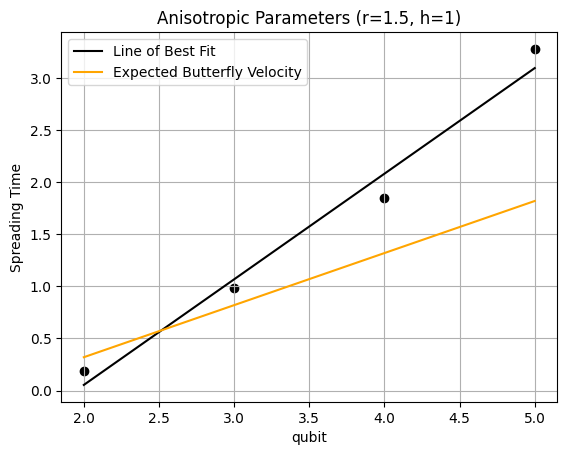

In [58]:
#Plots the spreading time for each qubit, and then finds the line of best fit to calculate the butterfly velocity.
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(2, len(spread)+1)]
y = spread[1:, 0]
ax.scatter(x, y, color = 'k')
ax.grid()

#Calculates and plots the line of best fit for the spreading times.
m, b = np.polyfit(x, y, 1)
ax.plot(x, [m*i+b for i in x], color = 'k', label = 'Line of Best Fit')

#Plots the expected butterfly velocity .
ax.plot(x, [1/2*(i-1)-0.18 for i in x], color = 'orange', label = 'Expected Butterfly Velocity')

#Sets up axis headings, title and the legend.
ax.set(xlabel = 'qubit', ylabel = 'Spreading Time', title = 'Anisotropic Parameters (r=1.5, h=1)')
ax.legend()

#Displays the numerically calculated butterfly velocity.
print(1/m)

## Group Velocity Graphs

(-4.0, 4.0)

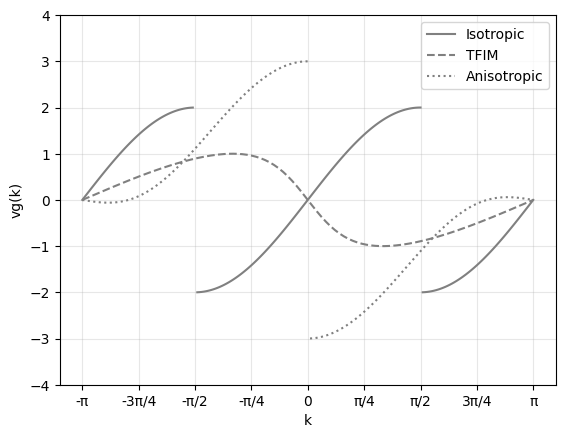

In [3]:
#Function to calculate the group velocity for given momentum x and Hamiltonian parameters r and h (J=1).
def GroupVelocity(x, r, h):
    return -2*(np.sin(x)*(h-np.cos(x))+r**2*np.sin(x)*np.cos(x))/(np.sqrt((h-np.cos(x))**2+r**2*np.sin(x)**2))

#Calculates the group velocity between -π and π for the three parameter sets.
x1a = [i*0.01*np.pi-np.pi for i in range(0, 50)]
x1b = [i*0.01*np.pi-np.pi for i in range(51, 151)]
x1c = [i*0.01*np.pi-np.pi for i in range(151, 201)]
y1a = [2*np.sin(i)*(np.sign(np.cos(i))) for i in x1a]
y1b = [2*np.sin(i)*(np.sign(np.cos(i))) for i in x1b]
y1c = [2*np.sin(i)*(np.sign(np.cos(i))) for i in x1c]

x2a = [i*0.01*np.pi-np.pi for i in range(0, 100)]
x2b = [i*0.01*np.pi-np.pi for i in range(101, 201)]
y2a = [GroupVelocity(i, 1.5, 1) for i in x2a]
y2b = [GroupVelocity(i, 1.5, 1) for i in x2b]
x2a.append(0)
y2a.append(3)

x3 = [i*0.01*np.pi-np.pi for i in range(0, 201)]
y3 = [GroupVelocity(i, 1, 0.5) for i in x3]

#Plots the group velocity curves for all three parameter sets.
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x1a, y1a, label = 'Isotropic', color = 'grey')
ax.plot(x1b, y1b, color = 'grey')
ax.plot(x1c, y1c, color = 'grey')
ax.plot(x3, y3, label = 'TFIM', color = 'grey', linestyle = '--')
ax.plot(x2a, y2a, label = 'Anisotropic', color = 'grey', linestyle = 'dotted')
ax.plot(x2b, y2b, color = 'grey', linestyle = 'dotted')

# #Annotates the maximum group velocity (i.e. butterfly velocity) for each parameter set.
# ax.scatter(-np.pi/2-0.042, 2, color = 'C0', sizes = [10])
# ax.scatter(-0.02, 3, color = 'C1', sizes = [10])
# ax.scatter(-np.pi/3, 1, color = 'C2', sizes = [10])

# ax.annotate("(-π/2, 2)", (-np.pi/2-0.45, 2.25))
# ax.annotate("(0, 3)", (-0.2, 3.25))
# ax.annotate("(-π/3, 1)", (-np.pi/3-0.3, 1.25))

#Creates x-axis ticks.
theta = np.arange(-np.pi, np.pi+np.pi/4, step=(np.pi / 4))
plt.xticks(theta, ['-π', '-3π/4', '-π/2', '-π/4', '0', 'π/4', 'π/2', '3π/4', 'π'])

#Adjusts the graph and adds legend.
ax.grid(alpha = 0.3)
ax.set(xlabel = 'k', ylabel = 'vg(k)')
ax.legend()
axes = plt.gca()
axes.set_ylim([-4, 4])

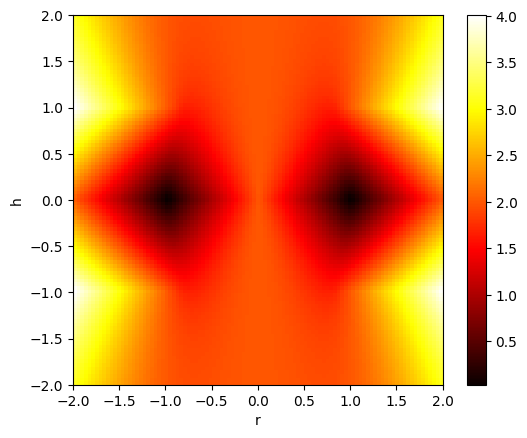

In [62]:
# #Function to calculate the group velocity for given momentum x and Hamiltonian parameters r and h (J=1).
# def GroupVelocity(x, r, h):
#     return -2*(np.sin(x)*(h-np.cos(x))+r**2*np.sin(x)*np.cos(x))/(np.sqrt((h-np.cos(x))**2+r**2*np.sin(x)**2))

# def ButterflyVelocity(r, h):
#     k = [i*0.01*np.pi-np.pi for i in range(0, 200)]
#     vg = []
#     for x in k:
#         vg.append(GroupVelocity(x, r, h))
#     return max(vg)

# rRange = 101
# hRange = 101

# xcoords = np.zeros((rRange, 1))
# ycoords = np.zeros((hRange, 1))
# vBcoords = np.zeros((hRange, rRange))

# for r in range(0, rRange):
#     xcoords[r] = r/25-2
#     for h in range(0, hRange):
#         ycoords[h] = h/25-2
#         vBcoords[hRange-h-1][r] = ButterflyVelocity(r/25-2.01, h/25-2.01)

import matplotlib.cm as cm
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set(xlabel = 'r', ylabel = 'h')
ax = plt.imshow(vBcoords, extent=(np.amin(xcoords), np.amax(xcoords), np.amin(ycoords), np.amax(ycoords)),
        cmap=cm.hot)
plt.colorbar()

## Quantum Circuit for YKY Protocol

In [ ]:
#Imports qiskit libraries needed to create the circuit.
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.circuit.library import UnitaryGate

#Creates a function to generate a circuit for the YKY protocol with given time evolutions U and U* on given number of
#total qubits, and measuring the OTOC on target qubit.
def YKYQuantum(totalQubits, U, UConj, target, qr):

    #Creates two classical registers to store results of measurements.
    cr = ClassicalRegister(2, 'c0')
    cr2 = ClassicalRegister(2, 'c1')

    #Creates quantum circuit object with given quantum and classical registers.
    YKY = QuantumCircuit(qr, cr, cr2)

    #Creates Bell basis states on top two and bottom two qubits then entangles remaining qubits in Bell basis states.
    YKY.h(qr[0])
    YKY.cx(qr[0], qr[1])
    YKY.h(qr[-2])
    YKY.cx(qr[-2], qr[-1])
    for i in range(2, int(totalQubits/2)):
        YKY.h(qr[i])
        YKY.cx(qr[i], qr[-(i+1)])

    #Ads the time evolutions U and U* to the circuit, with U* applying to qubits in reverse order.
    YKY.append(U, [qr[i] for i in range(1, int(totalQubits/2))])
    YKY.append(UConj, [qr[-i] for i in range(2, int(totalQubits/2)+1)])

    #Performs reverse Bell transform on target qubit and its entangled partner.
    YKY.cx(qr[target], qr[-1*(target+1)])
    YKY.h(qr[target])

    #Measures target qubit and its entangled partner in the computational basis.
    YKY.measure([target, -1*(target+1)], cr)

    #Performs reverse Bell transform on top and bottom qubits.
    YKY.cx(qr[0], qr[-1])
    YKY.h(qr[0])

    #Measures top and bottom qubits in the computational basis.
    YKY.measure([0, -1], cr2)

    return YKY

## Quantum Commutator as function of time

In [ ]:
#Imports qiskit libraries for sampling quantum measurements.
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeTorino

#Loads in Riemannian Trust Regions calculated matrices from Matlab.
import scipy.io
mat_contents = scipy.io.loadmat('Hamiltonians5Param1.mat')
my_tensor = mat_contents['x']

#Sets up the chosen backend (choice between noiseless AerSimulator, noisy FakeTorino simulator and actual IBM device).
backend = AerSimulator.from_backend(FakeTorino())
# backend = AerSimulator()
# service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")
# backend = service.backend("ibm_kyiv")
# backend = AerSimulator.from_backend(real_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

#Sets up variables for problem including number of qubits, number of time jumps, depth of Riemannian Trust Region circuits and target qubit.
qubits = 5
time = 5
m = 7
target = 5
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')

#Sets up arrays to store results of OTOC calculations from quantum calculations and exact classical calculations.
C = np.zeros((2*time+1, 5))
Cexact = np.zeros((10*time+1, 1))
xcoords = np.zeros((10*time+1, 1))

#Sets up variables for Hamiltonian.
J = 1
r = 0
h = 0

#Generates Hamiltonian matrix for given parameters.
H = XY(qubits, J, r, h)
isa_circuit = []

#Generates sampler for quantum measurements with given backend.
shots = 10000
sampler = Sampler(backend)

#For each discrete time increment, creates the Riemannian Trust Region circuit for time evolution, then applies YKY protocol, and stores in a list.
for l in range(0, 2*time+1):

    #Quantum circuits for both U and U*.
    U = QuantumCircuit(qubits)
    UConj = QuantumCircuit(qubits)

    #For each layer of the circuit, adds the 2-qubit RTR gate (in reverse order due to right-multiplication vs. left-multiplication)
    #on relevant qubits.
    for i in range(0, m):
        if (m-1-i)%2 == 1:
            for j in range(0, int(qubits/2)):
                U.append(UnitaryGate(my_tensor[:, :, m-1-i, l]), [2*j, 2*j+1])
                UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj()), [2*j, 2*j+1])
        else:
            for j in range(0, int((qubits-1)/2)):
                U.append(UnitaryGate(my_tensor[:, :, m-1-i, l]), [2*j+1, 2*j+2])
                UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l].conj()), [2*j+1, 2*j+2])

    # #Exact time evolution matrix calculated classically, then converted to a quantum gate for testing purposes.
    # UMatrix = linalg.expm(-1j*H*l/2)
    # U = UnitaryGate(UMatrix, label='U')
    # UConj = UnitaryGate(UMatrix.conj())

    #Performs YKY protocol with given time evolutions U and U*.
    OTOC = YKYQuantum(2*(qubits+1), U, UConj, target, OTOC_qr)

    isa_circuit.append(pass_manager.run(OTOC))

    print(l, ": done")

#Runs all the YKY circuits.
result = sampler.run(isa_circuit, shots = shots).result()

#Splits the results of quantum measurements for each point into 5 to generate a range of points.
for l in range(0, 2*time+1):
    t = l/2 

    counts = result[l].data
    for j in range(0, 5):

        #Measures P_EPR as prob of having 00 in c0, then post-selects on these states and calculates F_EPR as 
        #prob of having 00 in c1 given there was 00 in c0.
        prob = 0
        fid = 0
        for i in range(j*shots//5, (j+1)*shots//5):
            if counts.c0.array[i] == 0:
                prob += 1
                if counts.c1.array[i] == 0:
                    fid += 1

        #Normalises probabilities, and calculates OTOC as F = 1/(4*F_EPR).
        fid = fid/prob
        fid = 1/(4*fid)
        prob = prob/(shots//5)

        #Stores commutator C = 2-2*Re(F).
        C[l][j] = 2-2*fid

#Calculates exact values of operator-averaged infinite-temp commutator using classical computation for comparison.
W = [np.identity(2**qubits), GetX(1, qubits), GetY(1, qubits), GetZ(1, qubits)]
for m in range(0, 10*time+1):
    t = m/10
    V = [np.identity(2**qubits), GetX(target, qubits), GetY(target, qubits), GetZ(target, qubits)]

    U = linalg.expm(-1j*H*t)
    for k in range(0, 4):
        A = U.conj().T @ W[k] @ U
        for l in range(0, 4):              
            #Calculates OTOC functions F and then C for given j and t*tau.
            B = A @ V[l]
            F = np.trace(B @ B)/(2**qubits)
            Cexact[m] += 2-2*F.real

    Cexact[m] = Cexact[m]/16
    xcoords[m] = t

0 : done
1 : done
2 : done
3 : done
4 : done
5 : done
6 : done
7 : done
8 : done
9 : done
10 : done


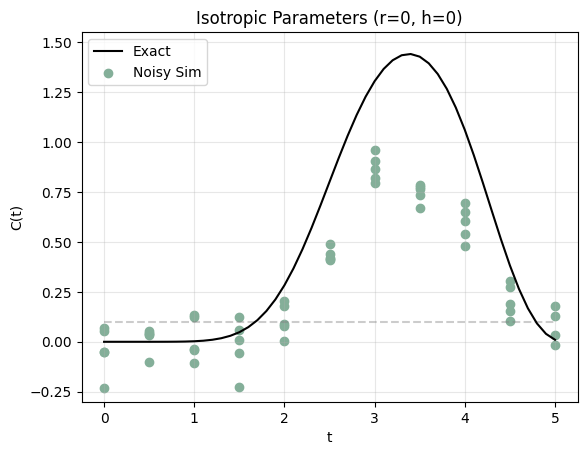

In [6]:
#Scatter plots quantum calculated values of commutator against exact classically computed values.
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

#Plots C = 0.1 to demonstrate spreading time.
ax.plot(xcoords, [0.1 for x in xcoords], '--', color = 'gray', alpha = 0.4)

#Plots exact classically computed commutator.
ax.plot(xcoords, Cexact, color = 'k', label = 'Exact')

#Scatter plots the 5 quantum calculated commutator values at each time increment.
for j in range(0, 5):
    if j == 0:
        ax.scatter(xcoords[::5], C[:, j], color = (133/256, 176/256, 154/256), label = 'Noisy Sim')
    else:
        ax.scatter(xcoords[::5], C[:, j], color = (133/256, 176/256, 154/256))

#Sets up axis titles, graph title and legend, as well as adjusting grid lines and variable values.
ax.set(xlabel = 't', ylabel = 'C(t)', title = 'Isotropic Parameters (r=0, h=0)')
ax.set_ylim([-0.3, 1.55])
ax.legend(loc = 2)
ax.grid(alpha = 0.3)

## Quantum RTR Butterfly Velocity

In [5]:
#Imports qiskit libraries for sampling quantum measurements.
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeTorino

#Sets up the chosen backend (choice between noiseless AerSimulator, noisy FakeTorino simulator and actual IBM device).
backend = AerSimulator.from_backend(FakeTorino())
# backend = AerSimulator()
# service = QiskitRuntimeService(channel="ibm_quantum", token="e4ab2a625dff8e9248c96dab970a348801426f1fcc3827f6db3cb5a073fefd797b691e864f7b4c3168ad574be854f9a94ba6dc3cf40bc761a43fd404838faed0")
# real_backend = service.backend("ibm_kyiv")
# backend = AerSimulator.from_backend(real_backend)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

#Loads in Riemannian Trust Regions calculated matrices from Matlab. Each qubit has RTR matrices for a time period of 0.2 in 
#time increments of 0.01 around the classical spreading time, to allow calculation of spreading time to high precision
#with reduced computation.
import scipy.io
mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit2.mat')
gatesqubit2 = mat_contents['x']
mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit3.mat')
gatesqubit3 = mat_contents['x']
mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit4.mat')
gatesqubit4 = mat_contents['x']
mat_contents = scipy.io.loadmat('Hamiltonians5Param3qubit5.mat')
gatesqubit5 = mat_contents['x']

# Set up variables for problem.
qubits = 5
OTOC_qr = QuantumRegister(2*(qubits+1), 'q')
m = 8

#Creates array to store spreading times for each qubit (other than qubit 1).
spreadRTR =  np.zeros((qubits-1, 1))
shots = 10000

#For each qubit calculates the spreading time to 0.01 precision by starting near the classically computed spreading time.
with Session(backend = backend) as session:
    sampler = Sampler(mode=session)
    for j in range(2, qubits+1):
        spreadCheck = False
        l = 0

        #Sets up the range of t and the RTR matrices for the given target qubit.
        if j == 2:
            t = 0
            my_tensor = gatesqubit2
        elif j == 3:
            t = 0.8
            my_tensor = gatesqubit3
        elif j == 4:
            t = 1.6
            my_tensor = gatesqubit4
        else:
            t = 2.6
            my_tensor = gatesqubit5

        #Finds the spreading time for qubit j as t_spread = min_t{C_j(t)>0.1}.
        while spreadCheck == False:
            t += 0.01
            l += 1

            #Quantum circuits for time evolutions U and U*.
            U = QuantumCircuit(qubits)
            UConj = QuantumCircuit(qubits)

            #For each layer of the circuit, adds the 2-qubit RTR gate (in reverse order due to right-multiplication vs. left-multiplication)
            #on relevant qubits.            
            for i in range(0, m):
                if (m-1-i)%2 == 0:
                    for k in range(0, int(qubits/2)):
                        U.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1]), [2*k, 2*k+1])
                        UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1].conj()), [2*k, 2*k+1])
                else:
                    for k in range(0, int((qubits-1)/2)):
                        U.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1]), [2*k+1, 2*k+2])
                        UConj.append(UnitaryGate(my_tensor[:, :, m-1-i, l-1].conj()), [2*k+1, 2*k+2])

            #Performs YKY protocol with given time evolutions U and U*.            
            OTOC = YKYQuantum(2*(qubits+1), U, UConj, j, OTOC_qr)
            isa_circuit = pass_manager.run(OTOC)
            result = sampler.run([isa_circuit], shots = shots).result()

            #Measures P_EPR as prob of having 00 in c0, then post-selects on these states and calculates F_EPR as 
            #prob of having 00 in c1 given there was 00 in c0.
            counts = result[0].data
            prob = 0
            fid = 0
            for i in range(0, shots):
                if counts.c0.array[i] == 0:
                    prob += 1
                    if counts.c1.array[i] == 0:
                        fid += 1

            #Normalises probabilities, and calculates OTOC as F = 1/(4*F_EPR).
            fid = fid/prob
            fid = 1/(4*fid)
            prob = prob/shots

            #Calculates commutator C = 2-2*Re(F).
            C = 2-2*fid

            print(t)

            #Checks if spreading time condition is met, and if so stores t and moves on to next qubit.
            if C > 0.1:
                spreadRTR[j-2] = t-0.01
                spreadCheck = True

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.8500000000000001
0.8600000000000001
0.8700000000000001
0.8800000000000001
1.61
1.62


[1.3986014]


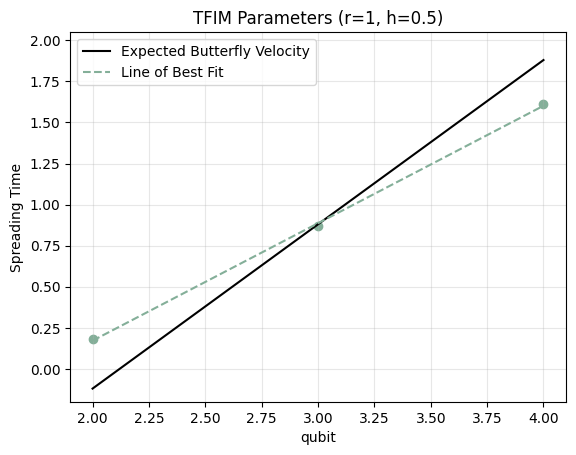

In [6]:
#Plots the spreading time for each qubit, and then finds the line of best fit to calculate the butterfly velocity.
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(2, len(spreadRTR)+2)]
y = spreadRTR
ax.scatter(x, y, color = (133/256, 176/256, 154/256))
ax.grid(alpha = 0.3)

#Calculates the line of best fit for the spreading times.
m, b = np.polyfit(x, y, 1)

#Plots the expected butterfly velocity .
ax.plot(x, [(i-1)-1.18 for i in x], label = 'Expected Butterfly Velocity', color = 'k')

#Plots the line of best fit for the spreading times.
ax.plot(x, [m*i+b for i in x], '--', label = 'Line of Best Fit', color = (133/256, 176/256, 154/256))

#Sets up axis headings, title and the legend.
ax.set(xlabel = 'qubit', ylabel = 'Spreading Time', title = 'TFIM Parameters (r=1, h=0.5)')
ax.set_ylim([-0.2, 3])
ax.legend(loc = 2)

#Displays the numerically calculated butterfly velocity.
print(1/m)